# Manual to derive and plot NDVI From Sentinel-3 SLSTR Data 

## Introduction - Reading in the Sentinel 3 Level 1B datasets

The first step in this process is to ingest the Sentinel 3 SLSTR data in an efficient manner. I choose to use xarray to open the dataset mainly because of its functionality for multidimensional data. Since every .nc file in the SLSTR datsaset consists of multiple bands, it is of interest to use a library that handles this data efficiently. To get a visual understanding of what lies in an .nc file, one can use the ESA SNAP program to do so. 

For the NDVI we use the Red band and the NIR (Near Infra Red Band), in order to correctly identify the bands of sentinel 3 that will give us the NDVI, we look at the central wavelength of the spectral bands in the documentation [1].

From [1] it is understood that Band 2 i.e., with central wavelength 0.659 μm corresponds to the Red Band, and Band 3 with the central wavelength 0.870 μm corresponds to the NIR Band. Hence, we read in the Radiance data of bands 2 and 3.

It takes this routine ~4 mins to run on my system (16GB RAM, 8 cores).

### Loading Dependencies and Reading the Data

/home/rach/miniconda3/envs/cmts_learn_slstr/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45625 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:41225' processes=4 threads=8, memory=15.36 GiB>
Dashboard link: http://127.0.0.1:45625/status


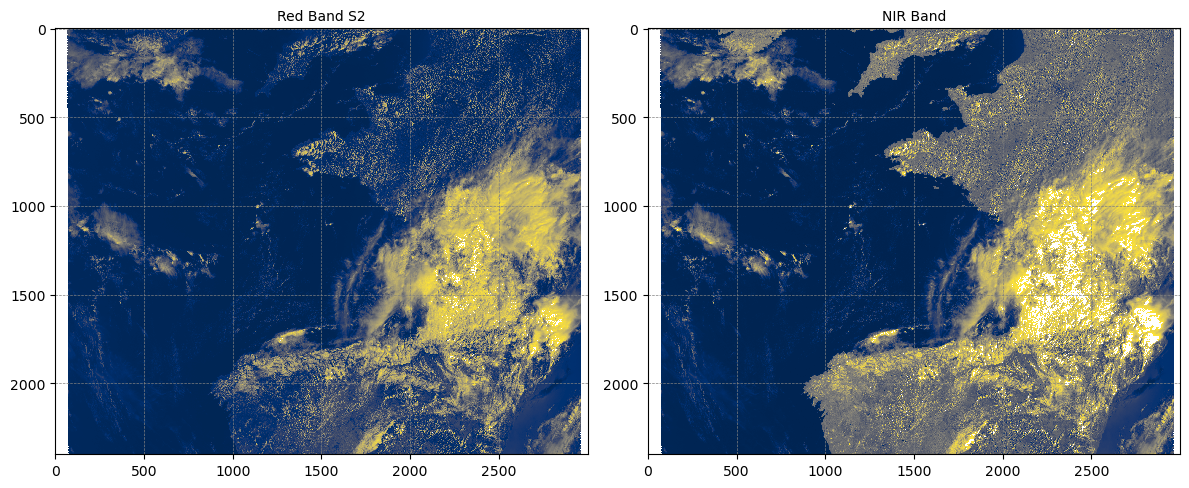

Elapsed time: 9.00 seconds


2025-05-09 12:25:28,156 - distributed.scheduler - WARNING - Worker failed to heartbeat for 568s; attempting restart: <WorkerState 'tcp://127.0.0.1:38127', name: 3, status: running, memory: 23, processing: 0>
2025-05-09 12:25:28,193 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:38127' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('transpose-d720c2b3fa11f1beab9daea9f76c00fb', 0, 2), ('transpose-6d3d0e93eb480afd6380d7f71d2bb618', 0, 0), ('transpose-d720c2b3fa11f1beab9daea9f76c00fb', 1, 0), ('transpose-6d3d0e93eb480afd6380d7f71d2bb618', 4, 3), ('transpose-6d3d0e93eb480afd6380d7f71d2bb618', 4, 0), ('transpose-6d3d0e93eb480afd6380d7f71d2bb618', 1, 1), ('transpose-6d3d0e93eb480afd6380d7f71d2bb618', 2, 0), ('transpose-d720c2b3fa11f1beab9daea9f76c00fb', 2, 4), ('transpose-6d3d0e93eb480afd6380d7f71d2bb618', 3, 4), ('transpose-6d3d0e93eb480afd6380d7f71d2bb618', 0, 2), ('transpose-d720c2b3fa11f1beab9daea9f76c00fb', 4, 1), ('transp

In [1]:
import dask.array as da
import numpy as np
import math
from time import time
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import cartopy.crs as ccrs
import cartopy.feature as cfeature

cluster=LocalCluster()
client=Client(n_workers=4, threads_per_worker=2)

print(client)
print(f"Dashboard link: {client.dashboard_link}") 

product = "/home/rach/learn-slstr/Trial_Data/S3A_SL_1_RBT____20190621T103916_20190621T104216_20210113T083124_0180_046_108_2160_LR1_R_NT_004.SEN3"  # Enter the path to the .sen3 folder

start_time = time()


#Read in Red Band i.e. S2 data and NIR Band i.e. S3 data
s2_an = xr.open_dataset(product + "/S2_radiance_an.nc")["S2_radiance_an"]
s3_an = xr.open_dataset(product + "/S3_radiance_an.nc")["S3_radiance_an"]

# Load the latitude and longitude data from NetCDF files
lon = xr.open_dataset(product+'/geodetic_an.nc')['longitude_an'].values
lat = xr.open_dataset(product+'/geodetic_an.nc')['latitude_an'].values

# lets visualise them as a first impression, looking at our data always helps!
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image (Red Band S2)
axes[0].imshow(s2_an, cmap='cividis', interpolation='none') 
axes[0].set_title(f'Red Band S2', fontsize=10)
axes[0].grid(True, which='both', color='gray', linestyle='--', linewidth=0.5) 

# Plot the second image (NIR Band)
axes[1].imshow(s3_an, cmap='cividis', interpolation='none')  
axes[1].axis('on')  # Show axes
axes[1].set_title(f'NIR Band', fontsize=10)
axes[1].grid(True, which='both', color='gray', linestyle='--', linewidth=0.5) 

plt.tight_layout()

plt.show()
end_time = time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

Now that the radiance files have been visualised, it is time to delve into the pre processing which includes conversion of radiance to reflectance. This is done mainly to switch to a more standard and comparable form of data i.e., reflectance as described in [2]. 
To do this we need solar irradiance values and solar zenith angle values which are provided in the "quality" file and "geometry" file

Dimensions of sza_resmp: (2400, 3000)


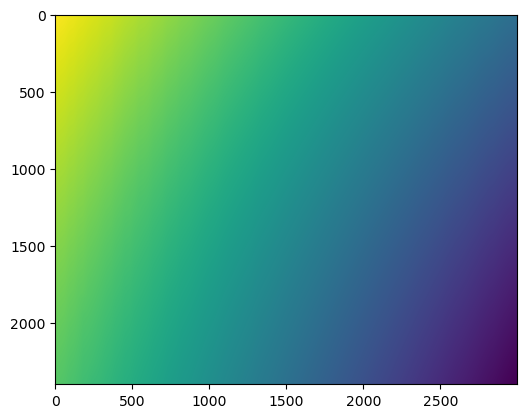

In [2]:
#Let's read in the solar irradiance from the quality file of s2 and s3, fyi for bands 1-4 only 'a' grid measurements exist so we use them in nadir view. 
#Nadir view is preferred due to a reduction in atmospheric path length when compared to oblique view

solar_irradiance_s2 = xr.open_dataset(product + "/S2_quality_an.nc")["S2_solar_irradiance_an"]
s2_irradiance=solar_irradiance_s2.values[0]  # this is done because solar irradiance is given a constant value band wise. 
# to understand the values we can look at the figure 4 (page 20) of Thullier et al., (2003) where wavelength is plotted against irradiance.

solar_irradiance_s3 = xr.open_dataset(product + "/S3_quality_an.nc")["S3_solar_irradiance_an"]
s3_irradiance=solar_irradiance_s3.values[0]

#read in the detectors array 
detectors = xr.open_dataset(product + "/indices_an.nc")["detector_an"]

#to calculate reflectance we also need the solar zenith angle values which is found in the geometry file. 
sza = xr.open_dataset(product + "/geometry_tn.nc")["solar_zenith_tn"]
plt.imshow(sza)
#remove NaN colums from the solar zenith angle 
sza_clean = sza[:1200, :100]
#plt.imshow(sza_clean)

#One has to resample the sza_clean for the whole radiance image 
sza_resampled = zoom(sza_clean.values, (s3_an.shape[0] / sza_clean.shape[0], s3_an.shape[1] / sza_clean.shape[1]), order=1)
print("Dimensions of sza_resmp:", sza_resampled.shape)
plt.imshow(sza_resampled)

Here we now rechunk data to make the code Dask compatible.

In [3]:
s2_an=s2_an.chunk({"rows" : 512, "columns" : 512})
s3_an=s3_an.chunk({"rows" : 512, "columns" : 512})
detectors=detectors.chunk({"rows" : 512, "columns" : 512})
sza_resampled = xr.DataArray(sza_resampled, dims=s2_an.dims, coords=s2_an.coords)
sza_resampled = sza_resampled.chunk({"rows": 512, "columns": 512})

Now that we have all the values necessary to plug into the equation given section 8.2.9 of [2] we can implement a function to calculate reflectance from the radiance data. 

In [4]:
def calculate_reflectance_np(sza, radiance, det, solar_irradiance):
    #solar_irradiance = s_2_irradiance
    cos_sza = np.cos(np.radians(sza))
    reflectance = (np.pi * radiance / solar_irradiance) / cos_sza
    invalid_mask = np.isnan(sza) | np.isnan(radiance) | np.isnan(det)
    return np.where(invalid_mask, np.nan, reflectance)

s_2_reflectance = xr.apply_ufunc(
    calculate_reflectance_np,
    sza_resampled, s2_an, detectors, s2_irradiance,
    input_core_dims=[[], [], [], []],  # assume pixel-wise elementwise function
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.float64],
)

s_2_reflectance = s_2_reflectance.persist()

s_3_reflectance = xr.apply_ufunc(
    calculate_reflectance_np,
    sza_resampled, s3_an, detectors, s3_irradiance,
    input_core_dims=[[], [], [], []],  # assume pixel-wise elementwise function
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.float64],
)

s_3_reflectance = s_3_reflectance.persist()

/home/rach/miniconda3/envs/cmts_learn_slstr/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 109.88 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/rach/miniconda3/envs/cmts_learn_slstr/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 109.88 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Lets also define the functions to calculate the NDVI

In [5]:
def calculate_ndvi(red_reflectance, nir_reflectance):
    denominator = (nir_reflectance + red_reflectance).where((nir_reflectance + red_reflectance) != 0, 1e-10) 
    ndvi = (nir_reflectance - red_reflectance) / denominator
    ndvi = ndvi.clip(min=-1, max=1)
    return ndvi

Now that we have the reflectances, and the functions for the NDVI lets also mask out the clouds by using the cloud_an from the flag_an.nc file.The cloud_an is a bitmask file where different bit flags have different meaning and this can be read by using:

In [6]:
cloud_flag = xr.open_dataset(product + "/flags_an.nc")["cloud_an"]
cloud_flag.attrs

{'flag_masks': array([    1,     2,     4,     8,    16,    32,    64,   128,   256,
          512,  1024,  2048,  4096,  8192, 16384, 32768], dtype=uint16),
 'flag_meanings': 'visible 1.37_threshold 1.6_small_histogram 1.6_large_histogram 2.25_small_histogram 2.25_large_histogram 11_spatial_coherence gross_cloud thin_cirrus medium_high fog_low_stratus 11_12_view_difference 3.7_11_view_difference thermal_histogram spare spare'}

Onto the cloud masking!

This is the stage where we finally compute the reflectance (we were using lazy computations so far), and so this one takes time to run. It takes ~1 min on my system.

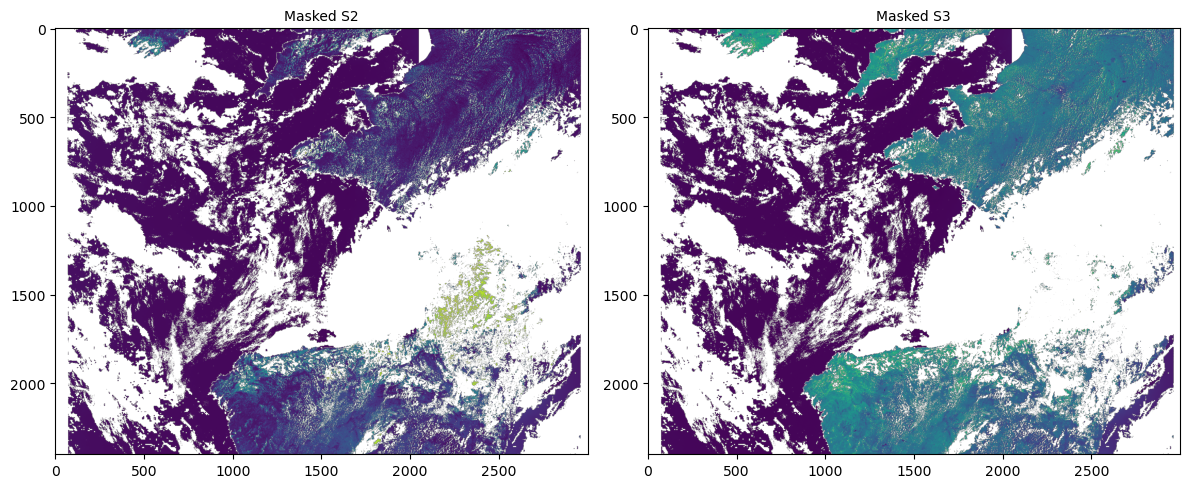

Elapsed time: 87.42 seconds


In [7]:
start_time = time()

#cloud_mask = (cloud_flag & (128 | 256 | 512 | 1024)) != 0 # first trial with grosscloud, medium_high, thin cirrus and fog_low_stratus.
cloud_mask = cloud_flag != 0 #mask if any pixel is flagged

# Mask out the cloud pixels in the reflectance data
s3_reflectance_clear = s_3_reflectance.where(~cloud_mask, np.nan)
s2_reflectance_clear = s_2_reflectance.where(~cloud_mask, np.nan)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image (Red Band S2)
axes[0].imshow(s2_reflectance_clear, cmap='viridis')
axes[0].set_title(f'Masked S2', fontsize=10)


# Plot the second image (NIR Band)
axes[1].imshow(s3_reflectance_clear, cmap='viridis')  
axes[1].axis('on')  # Show axes
axes[1].set_title(f'Masked S3', fontsize=10)


plt.tight_layout()

plt.show()
end_time = time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

Now that we have the cloud masked reflectance data, it is time to calculate the NDVI and visualise it with map coordinates. In general, from various literature it is understood that the values roughly between ~0-0.1 can be indicative of barren areas, with values between ~0.1 - 0.5 can indicate shrubs, grasslands or stressed vegetation while higher values of NDVI correspond to forests an healthy vegetation [e.g.,3,4]. For the visualisation, we mask out all the negative NDVI values that could indicate influence of water(or clouds/snow and other non vegetated surfaces). 

In [15]:
start_time = time()

#calculate NDVI 
NDVI = calculate_ndvi(s2_reflectance_clear, s3_reflectance_clear)
NDVI = NDVI.compute()
end_time = time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

Elapsed time: 0.40 seconds


In [12]:
import xrspatial.multispectral
from xrspatial.multispectral import ndvi
start_time = time()
ndvi_da = ndvi(s3_reflectance_clear, s2_reflectance_clear)
end_time = time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

Elapsed time: 0.01 seconds


In [16]:
start_time = time()
ndvi_n=(s3_reflectance_clear-s2_reflectance_clear)/(s3_reflectance_clear+s2_reflectance_clear)
end_time = time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

Elapsed time: 0.01 seconds


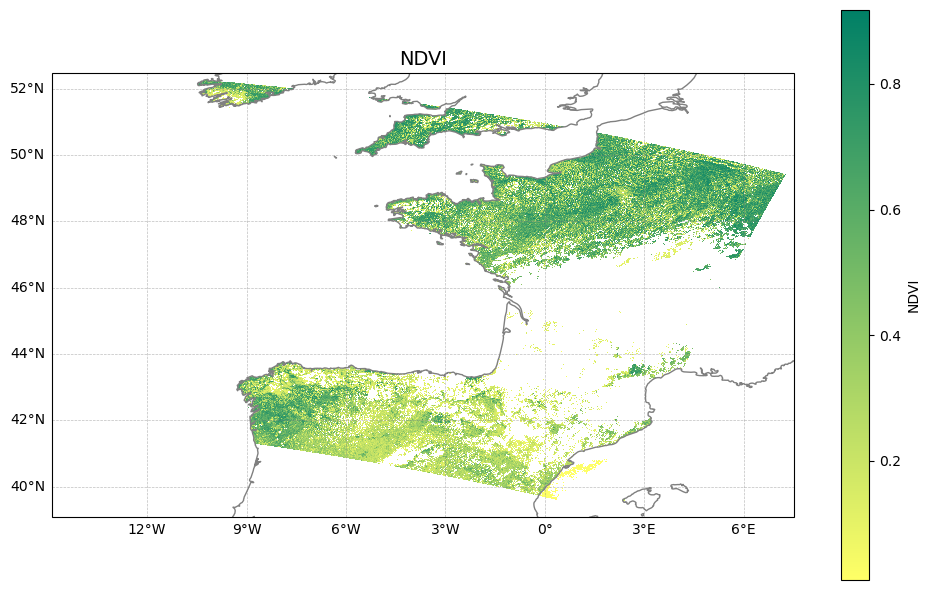

Elapsed time: 9.73 seconds


In [13]:
start_time = time()

#calculate NDVI 
NDVI = calculate_ndvi(s2_reflectance_clear, s3_reflectance_clear)
NDVI = NDVI.compute()

#Plotting the NDVI
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

NDVI_plot = ax.pcolormesh(lon, lat, NDVI.where(NDVI > 0, np.nan), cmap='summer_r', transform=ccrs.PlateCarree())

# Add gray coastlines to provide spatial context
ax.coastlines(color='gray')

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Add title and colorbar
ax.set_title('NDVI', fontsize=14)
plt.colorbar(NDVI_plot, ax=ax, label='NDVI')

plt.tight_layout()
plt.show()
end_time = time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

Now that we have the NDVI, let us save it to a .nc file together with the lat lon values as bands to facilitate mosaicking with other datasets. The reflectance of band S2 and S3 (cloud masked) are also exported as a single .nc file

In [14]:
VegetationIndice = xr.Dataset(
    {
        "NDVI": (("y", "x"), NDVI.data),
        "latitude": (("y", "x"), lat.data),
        "longitude": (("y", "x"), lon.data)
    }
)

# Add metadata
VegetationIndice.NDVI.attrs["Full form"] = "Normalized Difference Vegetation Index"
VegetationIndice.NDVI.attrs["units"] = "unitless"
VegetationIndice.latitude.attrs["units"] = "degrees_north"
VegetationIndice.longitude.attrs["units"] = "degrees_east"
VegetationIndice.attrs["title"] = "NDVI"
VegetationIndice.attrs["source"] = "Computed from Sentinel-3 Level 1B"

# Export to NetCDF
VegetationIndice.to_netcdf("NDVI_2160.nc") # change data name for different product


#The Reflectance Cloud Masked Data can also be exported if necessary
S2_3_Reflectance = xr.Dataset(
    {
        "Reflectance_S2": (("y", "x"), s2_reflectance_clear.data),
        "Reflectance_S3": (("y", "x"), s3_reflectance_clear.data),
        "CloudMask": (("y", "x"), cloud_mask.data)
           }
) 
S2_3_Reflectance.to_netcdf("Reflectance_2160.nc") # change data name for different product

In [ ]:
client.close()
cluster.close()

## References:
[1] https://user.eumetsat.int/resources/user-guides/sentinel-3-slstr-level-1-data-guide

[2] https://sentinel.esa.int/documents/247904/4598082/Sentinel-3-SLSTR-Land-Handbook.pdf

[3] Ozyavuz, M., Bilgili, B. C., & Salici, A. (2015). Determination of vegetation changes with NDVI method. Journal of environmental protection and ecology, 16(1), 264-273

[4] https://www.farm21.com/ndvi-images-ultimate-3-step-guide/